# <h1 style="text-align: center;">Langmuir isotherm predictions improved by modeling relative life with Gaussian process in benchmark comparison</h1>

<p style="text-align: center;">Jacob P. Krell<sup>a</sup>, David S. Mebane<sup>*a</sup></p>

<p style="text-align: center;"><sup>a</sup>Department of Mechanical and Aerospace Engineering, West Virginia University,
Morgantown, WV, 26506-6106, USA</p>

<sup>*</sup>david.mebane@mail.wvu.edu

---

## Abstract

The Langmuir isotherm model assumes constant relative life.[$^{[1]}$](#1) The Toth isotherm model modifies the Langmuir model to provide an empirical improvement. The Toth model was found to predict $q(T, p)$ measurements for zeolite 13X better than Langmuir, UNILAN, and Sips models.[$^{[2]}$](#2) However, as reported in this benchmark comparison, training Gaussian process (GP) regressions to relative life and maximum adsorbtion measurements performed even better than the Toth model. The advantage of this method, in addition to better predictions, is the simpler analytic form of the Langmuir model as compared to empirical modifications. Using the FoKL-GPy[$^{[3,4]}$](#3) Python package, the GPs may be exported into a symbolic Pyomo[$^{[5,6]}$](#5) model for nonlinear programming (NLP) optimization problems, taking full advantage of the simpler analytic form of the Langmuir isotherm model and the clear physical meaning of its parameters.

---

## Method

The nomenclature was largely taken from [[1]](#1). In order of appearance in the following equations,

- $\mathbf{GP} \equiv$ Gaussian process model trained using FoKL-GPy
- $\Delta \equiv$ exponent of relative life
- $T \equiv$ temperature
- $p \equiv$ pressure
- $\sigma_1 \equiv$ relative life
- $q \equiv$ amount adsorbed
- $\mu \equiv$ number of gas molecules striking each surface area per time
- $q_{max} \equiv$ maximum adsorption
- $M \equiv$ molecular weight of adsorbent
- $R \equiv$ universal gas constant
- $q_{cal} \equiv$ calculated predictions of amount adsorbed $q$
- $\sigma_{1, cal} \equiv$ calculated predictions of relative life $\sigma_1$
- $q_s \equiv$ Toth isotherm model parameter theoretically equal to maximum adsorption $q_{max}$
- $b \equiv$ Toth isotherm model parameter
- $t \equiv$ Toth isotherm model parameter

The GP model $\mathbf{GP}$ will be trained on $\Delta$ as a function of inverse temperature $T$ and natural logarithim of pressure $p$.

$$\tag{1} \mathbf{GP} = \{\Delta\ |\ T^{-1},\ \ln(p)\}$$

$$\tag{2} \Delta = \ln(\sigma_1)$$

$$\tag{3} \sigma_1 = \frac{q}{\mu(q_{max}-q)}$$

$$\tag{4} \mu = \frac{p}{\sqrt{2 \pi M R T}}$$

$$\tag{5} q_{max} = q_s$$

Then, to make predictions $q_{cal}$ from $\mathbf{GP}$,

$$\tag{6} q_{cal} = \frac{\sigma_{1, cal} q_{max} \mu}{1 + \sigma_{1, cal} \mu}$$

$$\tag{7} \sigma_{1, cal} = \exp(\mathbf{GP})$$

Note from Table 2 and Table 4 of [[2]](#2), respectively, experimental measurements $q(T, p)$ are saved as *data.txt* and Toth model parameters $(q_s, b, t)$ are saved as *toth.txt*. From Equation 2 of [[2]](#2), the Toth model is as follows.

$$\tag{8} q = \frac{q_s p}{(b+p^t)^{1/t}}$$

To obtain $q_{max}$ at any $(T, p)$ pair assuming $q_{max} \propto T$,

$$\tag{9} \mathbf{GP}_{q_{max}} = \{q_{max}\ |\ T\}$$

Since direct measurements of $q_{max}$ were not reported, $q_{max}=q_s$ was assumed for training $\mathbf{GP}_{q_{max}}$. This should yield an equivalent comparison with the Toth model. However, experimental or literature values in future work may produce a more physically accurate model.

---

## Implementation

Defining limits of where the GPs may be evaluated, increased at the cost of accuracy:

In [57]:
# # Increase bounds in order to extrapolate model at the cost of accuracy:
# T_min = 231  # Kelvin, temperature
# T_max = 611
# p_min = 11.9  # Pa, pressure
# p_max = 143e6

# Or, set to dataset min/max in order to maximize accuracy at the cost of no extrapolation:
T_min = 273.15  # Kelvin, temperature
T_max = 353.15
p_min = 67  # Pa, pressure
p_max = 102100

Importing modules and defining constants:

In [58]:
from FoKL import FoKLRoutines
from FoKL.fokl_to_pyomo import fokl_to_pyomo
import os
dir = os.path.abspath('')  # directory of notebook
# # -----------------------------------------------------------------------
# # UNCOMMENT IF USING LOCAL FOKL PACKAGE:
# import sys
# sys.path.append(os.path.join(dir, '..', '..'))  # package directory
# from src.FoKL import FoKLRoutines
# from src.FoKL.fokl_to_pyomo import fokl_to_pyomo
# # -----------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from tabulate import tabulate
import copy
import pyomo.environ as pyo
from pyomo.environ import *


M = 0.0440095  # molecular weight of CO2, kg/mol
R = 8.31446261815324  # universal gas constant, J/(K*mol)

Loading and parsing data:

In [59]:
# Experimental measurements:

data = np.loadtxt(os.path.join(dir, 'data', 'data.txt'), skiprows=2)  # experimental measurements q(T, p)

T = data[:, 0]  # K
p_kPa = data[:, 1]  # kPa
p = p_kPa * 1e3  # kPa to Pa
q = data[:, 2]  # mol/kg

T_const = np.where(T[:-1] != T[1:])[0]  # indices where experiment ends (i.e., where next temperature changes)
T_const = np.insert(T_const + 1, [0, len(T_const)], [0, len(T)])  # indices where experiments begin (including "next" experiment enabling 'data[T_const[i]:T_const[i + 1], :]')
n = len(T_const) - 1  # number of experiments
nd = np.array(list(T_const[i + 1] - T_const[i] for i in range(n)))  # number of datapoints in each experiment

# Toth model:

toth = np.loadtxt(os.path.join(dir, 'data', 'toth.txt'), skiprows=2)  # model parameters (qs, b, t)

qs = np.repeat(toth[:, 1], nd)  # mol/kg, 'np.repeat(x, nd)' for repeating experiments' single values at each datapoint
b = np.repeat(toth[:, 2], nd)  # kPa
t = np.repeat(toth[:, 3], nd)

Defining equations:

In [60]:
def eq2(sigma1):
    """Delta"""
    return np.log(sigma1)

def eq3(q, mu, qmax):
    """sigma1"""
    return q / mu / (qmax - q)

def eq4(p, M, R, T):
    """mu"""
    return p / np.sqrt(2 * np.pi * M * R * T)

def eq6(sigma1, qmax, mu):
    """qcal"""
    return sigma1 * qmax * mu / (1 + sigma1 * mu)

def eq8(qs, b, t, p_kPa):
    """qcal_Toth, where p is in kPa. Equation 2 of [2]."""
    return qs * p_kPa / (b + p_kPa ** t) ** (1 / t)

Calculating training set $\{\Delta\ |\ T^{-1},\ \ln(p)\}$:

In [61]:
mu = eq4(p, M, R, T)
qmax = qs
sigma1 = eq3(q, mu, qmax)
Delta = eq2(sigma1)

inv_T = 1 / T
ln_p = np.log(p)

Training $\mathbf{GP}$:

In [62]:
GP = FoKLRoutines.FoKL(kernel=1, UserWarnings=False)
_ = GP.fit([inv_T, ln_p], Delta, clean=True, minmax=[[1 / T_max, 1 / T_min], [np.log(p_min), np.log(p_max)]])

[1, -384.15314356452586]
[2, -596.4859900152487]
[2, -693.4041573239342]
[3, -710.2677235477411]
[3, -710.2677235477411]
[4, -718.6136256430942]
[4, -718.6136256430942]
[4, -758.1856392676851]
[5, -759.558023477218]
[5, -784.4975723128669]
[5, -784.4975723128669]
[6, -784.4975723128669]
[6, -788.920476638966]
[6, -802.2634430455162]
[6, -802.2634430455162]
[7, -805.4457827829906]
[7, -805.4457827829906]
[7, -808.6291570413414]
[7, -839.6239587090463]
[8, -840.9502136225358]
[8, -847.6549520827847]
[8, -866.78669643117]
[8, -866.78669643117]
[8, -867.7591717332308]
[9, -867.7591717332308]
[9, -875.7802770866986]
[9, -875.7802770866986]
[9, -875.7802770866986]
[9, -879.1095537674979]
[10, -880.0818668089578]
[10, -906.4640699959346]
[10, -906.4640699959346]
[10, -912.8117084316456]
[10, -908.3592743383929]
[10, -908.3592743383929]
[11, -908.3592743383929]


Inpsecting validation plot to confirm accuracy of $\mathbf{GP}$:

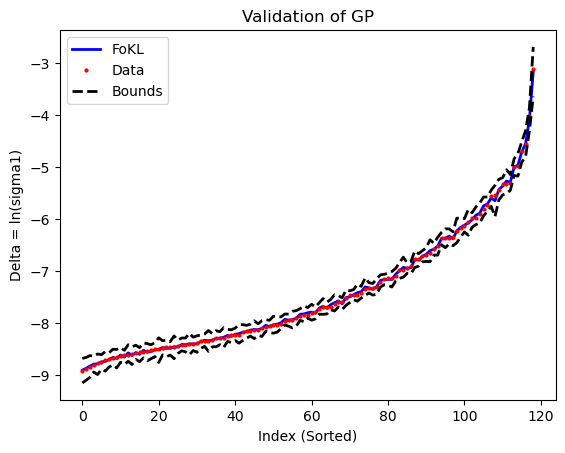

RMSE = 0.0010731012630974973


In [63]:
_, _, rmse = GP.coverage3(plot='sorted', ylabel='Delta = ln(sigma1)', title='Validation of GP')
print(f"RMSE = {rmse}")

Plotting $\mathbf{GP}$ at each experimental temperature:

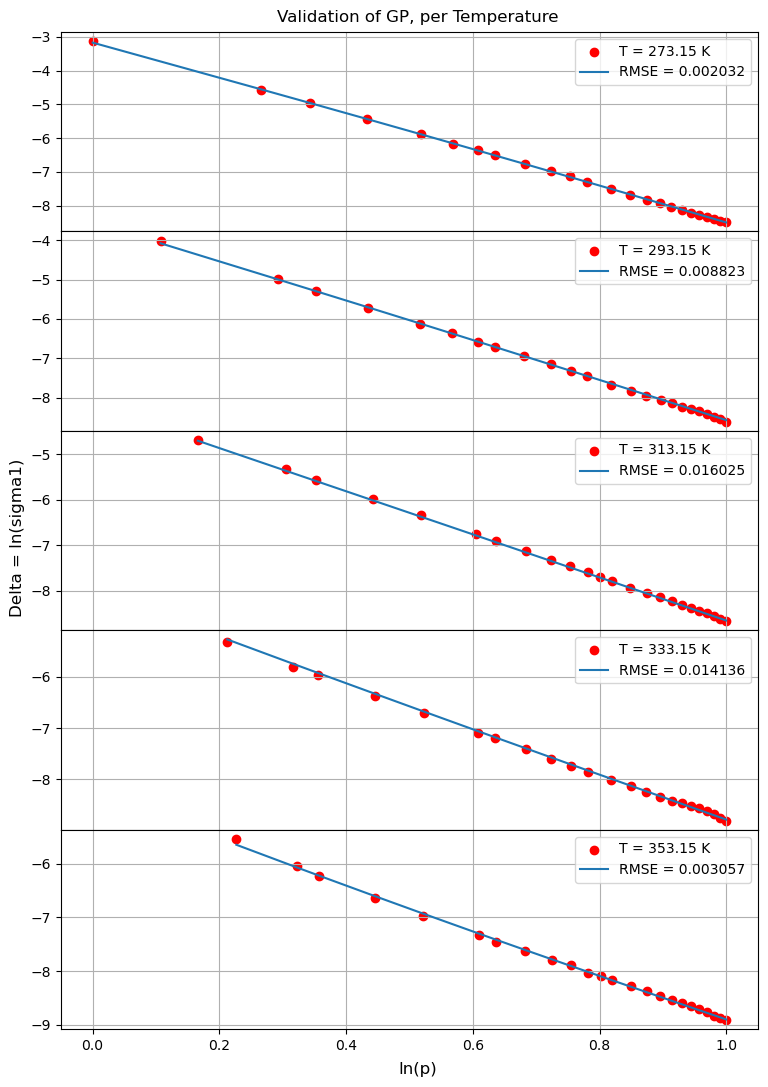

In [64]:
fig, axs = plt.subplots(n, figsize=(8.5, 11), sharex=True)
offset = 0.04
plt.subplots_adjust(left=2*offset, bottom=4*offset/3, top=1-offset, hspace=0)
fig.suptitle('Validation of GP, per Temperature')
fig.supxlabel('ln(p)')
fig.supylabel('Delta = ln(sigma1)')
for i in range(n):
    j, k = T_const[i], T_const[i + 1]
    inputs_i, data_i = GP.inputs[j:k, :], GP.data[j:k]
    Delta_i, _, rmse_i = GP.coverage3(inputs=inputs_i, data=data_i)
    ln_p_i = inputs_i[:, 1]

    axs[i].scatter(ln_p_i, data_i, color='r', label=f"T = {np.round(T[j], 2)} K")
    axs[i].plot(ln_p_i, GP.evaluate(inputs_i), label=f"RMSE = {np.round(rmse_i, 6)}")
    axs[i].legend()
    axs[i].grid()

Calculate $q_{cal}$ predictions for comparison:

In [65]:
Delta_cal = GP.evaluate()
sigma1_cal = np.exp(Delta_cal)
qcal = eq6(sigma1_cal, qmax, mu)  # GP

qcal_Toth = eq8(qs, b, t, p_kPa)  # Toth

Plotting data, GP model, and Toth model for comparison:

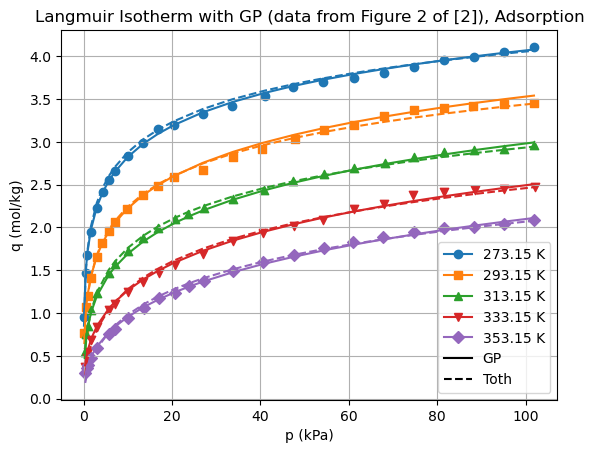

In [66]:
# Define styles and legend elements:

colors = mcolors.TABLEAU_COLORS  # dictionary of all colors
colors = list(colors.values())[:n]  # first 'n' colors, one per experiment

markers = ['o', 's', '^', 'v', 'D']
labels = list(f"{np.round(T[T_const[i]], 2)} K" for i in range(n))  # temperatures for legend

legend_elements = list(Line2D([0], [0], marker=markers[c], color=colors[c], label=labels[c]) for c in range(n)) + [Line2D([0], [0], ls='-', color='k', label='GP'), Line2D([0], [0], ls='--', color='k', label='Toth')]

# Plot:

fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    plt.scatter(p_kPa[j:k], q[j:k], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], qcal[j:k], '-', color=colors[i])  # GP model
    plt.plot(p_kPa[j:k], qcal_Toth[j:k], '--', color=colors[i])  # Toth model

ax.set_xlabel('p (kPa)')
ax.set_ylabel('q (mol/kg)')
ax.set_title('Langmuir Isotherm with GP (data from Figure 2 of [2]), Adsorption')
ax.legend(handles=legend_elements, loc='lower right')
ax.grid()

Training $\mathbf{GP}_{q_{max}}$ to obtain $q_{max}$ at any $T$, and validating:

[1, -17.694279663565077]
[2, -27.995758655660154]
[3, -28.794436856119365]
[4, -319.60810225620355]
[5, -319.60810225620355]
[6, -319.60810225620355]
[7, -319.60810225620355]


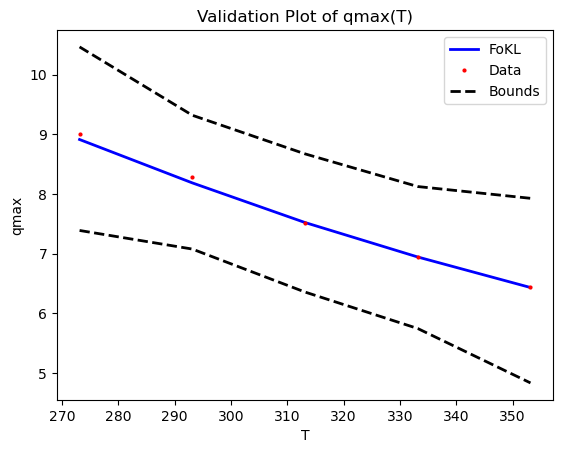

RMSE = 0.03514680268869572


In [67]:
# Training:
GP_qmax = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, atau=1e-6)
_ = GP_qmax.fit(T[T_const[:-1]], qmax[T_const[:-1]], clean=True, minmax=[[T_min, T_max]])

# Validation:
_, _, rmse = GP_qmax.coverage3(plot=True, xaxis=0, xlabel='T', ylabel='qmax', title='Validation Plot of qmax(T)')
print(f"RMSE = {rmse}")

Reproducing $q/p$ plot but with $\theta_1$ instead of $q$, and using $\mathbf{GP}_{q_{max}}$ for calculation of the GP's $\theta_1$ value which greatly reduces accuracy but provides visual of what Pyomo will be working with:

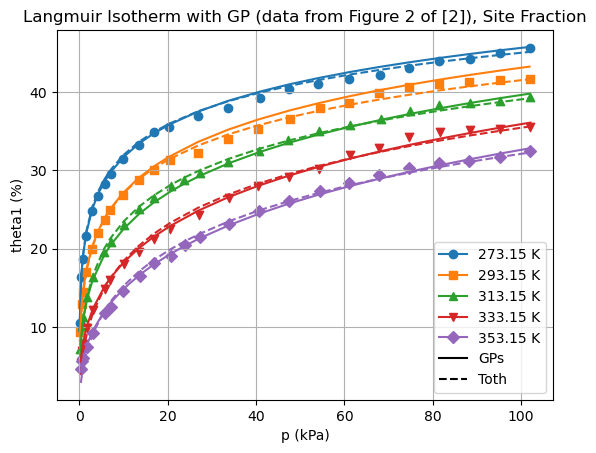

In [68]:
theta1_cal = np.zeros([sum(nd), 4])  # [measured, single GP, both GP's, Toth]

fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    theta1_cal[j:k, 0] = q[j:k] / qmax[j:k] * 100  # measured
    theta1_cal[j:k, 1] = qcal_Toth[j:k] / qmax[j:k] * 100  # Toth
    theta1_cal[j:k, 2] = qcal[j:k] / qmax[j:k] * 100  # single GP (for later percent error comparison)
    theta1_cal[j:k, 3] = qcal[j:k] / GP_qmax.evaluate(T[j:k], clean=True) * 100  # both GP's
    
    plt.scatter(p_kPa[j:k], theta1_cal[j:k, 0], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], theta1_cal[j:k, 1], '--', color=colors[i])  # Toth model
    plt.plot(p_kPa[j:k], theta1_cal[j:k, 3], '-', color=colors[i])  # GPs (uses GP_qmax for qmax, as Pyomo will use)

ax.set_xlabel('p (kPa)')
ax.set_ylabel('theta1 (%)')
ax.set_title("Langmuir Isotherm with GP (data from Figure 2 of [2]), Site Fraction")
ax.grid()

legend_elements_GPs = copy.deepcopy(legend_elements)
legend_elements_GPs[5].set_label('GPs')
_ = ax.legend(handles=legend_elements_GPs, loc='lower right')

Comparing prediction from GPs to Toth, and noting that the Toth model's average magnitude of percent error at each temperature (i.e., Table 1 below, rows 3-7, column 2) is expected to equal the last column $\Delta q$ of Table 4 of [[2]](#2) for zeolite 13X:

Table 1. Percent error of amount adsorbed predictions.
╒═════════════════════════╤════════╤══════╕
│                         │   Toth │   GP │
╞═════════════════════════╪════════╪══════╡
│ Average Magnitude (|%|) │   3.06 │ 1.48 │
├─────────────────────────┼────────┼──────┤
│ '', T = 273.15 K (|%|)  │   1.85 │ 0.78 │
├─────────────────────────┼────────┼──────┤
│ '', T = 293.15 K (|%|)  │   1.91 │ 1.15 │
├─────────────────────────┼────────┼──────┤
│ '', T = 313.15 K (|%|)  │   2.01 │ 1.45 │
├─────────────────────────┼────────┼──────┤
│ '', T = 333.15 K (|%|)  │   4.39 │ 2.1  │
├─────────────────────────┼────────┼──────┤
│ '', T = 353.15 K (|%|)  │   5.18 │ 1.95 │
├─────────────────────────┼────────┼──────┤
│ Average Value (%)       │  -1.12 │ 0.08 │
├─────────────────────────┼────────┼──────┤
│ Standard Deviation (%)  │   6.11 │ 2.05 │
╘═════════════════════════╧════════╧══════╛
Table 2. Percent error of site fraction predictions.
╒═════════════════════════╤════════╤══════╤═══════╕
│   

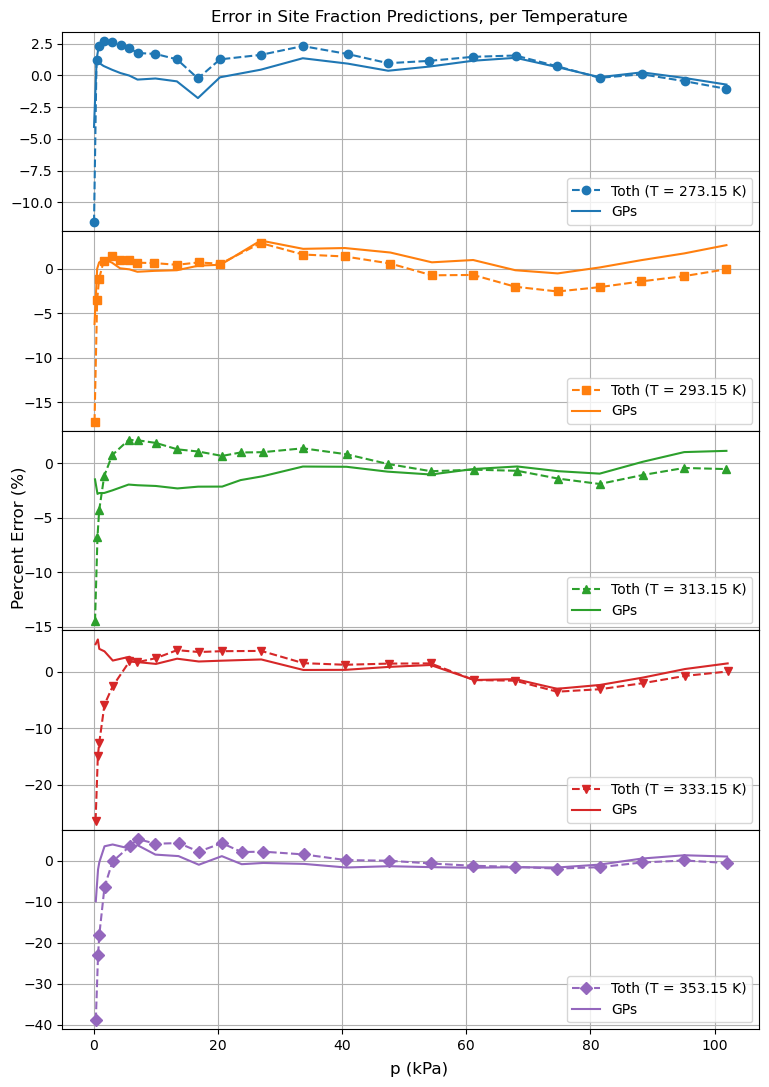

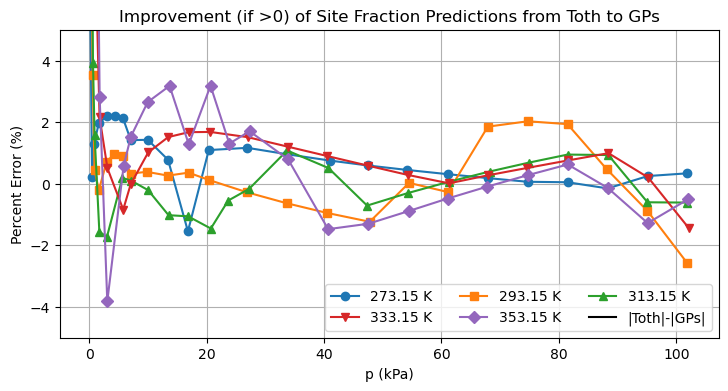

In [69]:
# Calculate percent errors:

qcal_perc_error = np.zeros([sum(nd), 2])  # [Toth, GP]
theta1_cal_perc_error = np.zeros([sum(nd), 3])  # [Toth, GP, GPs]

def perc_error(measured, predicted):
    """Return percent error."""
    return (predicted - measured) / measured * 100

qcal_perc_error[:, 0] = perc_error(q, qcal_Toth)  # should align with what is reported in [2]
qcal_perc_error[:, 1] = perc_error(q, qcal)  # single GP (Delta)

for i in range(3):
    theta1_cal_perc_error[:, i] = perc_error(theta1_cal[:, 0], theta1_cal[:, i + 1])

# -----------------------------
# Compare/Print percent errors:

_dec = 2  # decimals to round to
table_q = [['', 'Toth', 'GP'], 
           ['Average Magnitude (|%|)'] + np.round(np.mean(np.abs(qcal_perc_error), axis=0), _dec).tolist()] + \
           list([f"'', T = {np.round(T[T_const[i]], 2)} K (|%|)"] + np.round(np.mean(np.abs(qcal_perc_error[T_const[i]:T_const[i + 1]]), axis=0), _dec).tolist() for i in range(n)) + \
          [['Average Value (%)'] + np.round(np.mean(qcal_perc_error, axis=0), _dec).tolist(), 
           ['Standard Deviation (%)'] + np.round(np.std(qcal_perc_error, axis=0), _dec).tolist()]
print("Table 1. Percent error of amount adsorbed predictions.")
print(tabulate(table_q, headers='firstrow', tablefmt='fancy_grid'))
table_theta1 = [['', 'Toth', 'GP', 'GPs'], 
                ['Average Magnitude (|%|)'] + np.round(np.mean(np.abs(theta1_cal_perc_error), axis=0), _dec).tolist()] + \
                list([f"'', T = {np.round(T[T_const[i]], 2)} K (|%|)"] + np.round(np.mean(np.abs(theta1_cal_perc_error[T_const[i]:T_const[i + 1]]), axis=0), _dec).tolist() for i in range(n)) + \
               [['Average Value (%)'] + np.round(np.mean(theta1_cal_perc_error, axis=0), _dec).tolist(), 
                ['Standard Deviation (%)'] + np.round(np.std(theta1_cal_perc_error, axis=0), _dec).tolist()]
print("Table 2. Percent error of site fraction predictions.")
print(tabulate(table_theta1, headers='firstrow', tablefmt='fancy_grid'))

print(f"\nIncrease in Average Magnitude:\n    (GPs - Toth) / Toth \
= ({np.round(table_theta1[1][3], _dec)} - {np.round(table_theta1[1][1], _dec)}) / {np.round(table_theta1[1][1], _dec)} \
= {np.round((table_theta1[1][3] - table_theta1[1][1]) / table_theta1[1][1] * 100, _dec)} %\n")

# -----------------------
# Plot of percent errors:

fig, axs = plt.subplots(n, figsize=(8.5, 11), sharex=True)
offset = 0.04
fig.subplots_adjust(left=2*offset, bottom=4*offset/3, top=1-offset, hspace=0)
fig.suptitle('Error in Site Fraction Predictions, per Temperature')
fig.supxlabel('p (kPa)')
fig.supylabel('Percent Error (%)')
for i in range(n):
    j, k = T_const[i], T_const[i + 1]

    axs[i].plot(p_kPa[j:k], theta1_cal_perc_error[j:k, 0], '--', color=colors[i], marker=markers[i], label=f"Toth (T = {np.round(T[j], 2)} K)")  # Toth model, == qcal_perc_error[j:k, 0]
    axs[i].plot(p_kPa[j:k], theta1_cal_perc_error[j:k, 1], '-', color=colors[i], label='GPs')  # GPs
    
    axs[i].legend(loc='lower right')
    axs[i].grid()

# --------------------------------------
# Plot of improvement in percent errors:

theta1_cal_perc_error_diff = np.abs(theta1_cal_perc_error[:, 0]) - np.abs(theta1_cal_perc_error[:, 1])  # |Toth| - |GPs|

fig, ax = plt.subplots(figsize=(8.5, 4))
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    ax.plot(p_kPa[j:k], theta1_cal_perc_error_diff[j:k], '-', color=colors[i], marker=markers[i])  # |Toth| - |GPs|

ax.set_xlabel('p (kPa)')
ax.set_ylabel('Percent Error (%)')
ax.set_title("Improvement (if >0) of Site Fraction Predictions from Toth to GPs")
ax.grid()
_ = ax.set_ylim([-5, 5])

legend_elements_diff = copy.deepcopy(legend_elements[:6])
legend_elements_diff[5].set_label('|Toth|-|GPs|')
legend_elements_diff_T = [legend_elements_diff[i] for i in [0, 3, 1, 4, 2, 5]]
_ = ax.legend(handles=legend_elements_diff_T, ncol=3, loc='lower right')

### Conclusion

In Table 2, "GPs" refers to the use of $\mathbf{GP}_{q_{max}}$ in scaling $q_{cal}$ to $\theta_{1, cal}$. Recall both "Toth" and "GP" use $q_{max} = q_s$.

In regard to evaluating at any $(T, p)$ pair, the advantage of "GPs" is that the site fraction may be predicted; whereas, "GP" may only predict the amount adsorbed at $(T, p)$ with known $q_{max}=q_s$. "Toth", without the inclusion of $\mathbf{GP}_{q_{max}}$ or some other $q_{max}$ model, has the same limitation as "GP". For this reason, "GPs" is advantageous for the simple reason that it models $q_{max}$ across $T$.

The main concern in this benchmark comparison, then, is whether "GP" provides an improvement to "Toth". The percent errors are certainly lower and the average is much closer to $0$. Since "GPs" does not have a $1:1$ analogue and performs worse than "GP", as expected due to dependence on a second GP, the concern here is again in comparison to "Toth"; also, whether the decrease in performance compared to "GP" is significant so as to warrant a different method of modeling $q_{max}$ and ultimately the site fraction.

To the first concern regarding "GPs", Table 2 shows overall better performance than "Toth". However, the average magnitude, that is, the mean of the absolute values of the percent error, tends to be equal to that of "Toth" if the normalization bounds of the GP models are set to about a $160\%$ increase in the span. In other words, $(T,p)_{min} \lesssim (231 \text{ K}, 11.9 \text{ Pa})$ and $(T,p)_{max} \gtrsim (611 \text{ K}, 143 \text{ MPa})$, which marks $160\%$ since $\Delta \propto (T^{-1}, \ln(p))$, begins to show "Toth" outperforming "GPs". If set to the minimum and maximum bounds of the dataset, $(T,p)_{min} = (273.15 \text{ K}, 67 \text{ Pa})$ and $(T,p)_{max} = (353.15 \text{ K}, 102.1 \text{ kPa})$, in order to maximize model accuray at the cost of limiting extrapolation, then "GPs" outperforms "Toth" by about $45\%$. Due to the stochastic nature of GP models, this value will vary depending on the training of $\mathbf{GP}$ and $\mathbf{GP}_{q_{max}}$. See "Increase in Average Magnitude: (GPs - Toth) / Toth" in the above printed output for the actual percent increase or decrease. A negative value means "GPs" outperformed "Toth" on this metric, which is expected unless the normalization bounds are significantly increased.

To the second concern, the performace of "GPs" is very close to that of "GP". There is room for improvement but a different model of $q_{max}$ is unlikely to provide this improvement except by a little since the performance is already close. Nonetheless, decreasing the RMSE of $\mathbf{GP}_{q_{max}}$ will drive the performance of "GPs" closer to "GP". For significant improvement overall, though, the focus should instead be on decreasing the RMSE of $\mathbf{GP}$ itself. If "GP" improves, then "GPs" will improve as well.

"GPs" outperforms "Toth" overall, even if moderately expanding normalization bounds for extrapolation, and so proved successful in this benchmark comparison.

---

## Numerical Evaluation of Isotherm Model

To receive $q$ or $\theta_1$ at any $(T, p)$ pair, use $\mathbf{GP}$ and $\mathbf{GP}_{q_{max}}$. The following function receives $(T, p)$ and takes care of syntax and in-between calculations:

In [70]:
def q_and_theta1(T, p):
    """Pass temperature T (K) and pressure p (Pa) to GP. Pass T to GP_qmax. Return predictions of q and theta1."""
    # Get Delta, and recall GP was trained on [inv_T, ln_p]:
    inv_T = 1 / T
    ln_p = np.log(p)
    Delta = GP.evaluate([inv_T, ln_p], clean=True, SingleInstance=True)
    
    # Get qmax:
    sigma1 = np.exp(Delta)
    qmax = GP_qmax.evaluate([T], clean=True)
    mu = eq4(p, M, R, T)

    # Predict q and theta1:
    q = eq6(sigma1, qmax, mu)
    theta1 = q / qmax

    # Return predictions:
    return q[0], theta1[0]

For example, evaluate an arbitrary $(T, p)$ pair and print the results:

In [71]:
# Define arbitray T and p:
T_example = 291.8  # K
p_example = 63192  # Pa

# Evaluate:
q_and_theta1_predictions = q_and_theta1(T_example, p_example)

# Print results:
print(f"At arbitrary (T, p) = ({T_example} K, {p_example} Pa),\n")
print(f"          q = {np.round(q_and_theta1_predictions[0], 2)} mol/kg")
print(f"     theta1 = {np.round(q_and_theta1_predictions[1] * 100, 2)} %")

At arbitrary (T, p) = (291.8 K, 63192 Pa),

          q = 3.25 mol/kg
     theta1 = 39.46 %


---

## Application to Nonlinear Programming

Converting $\mathbf{GP}_{q_{max}}$ to Pyomo for any nonlinear programming (NLP) optimization problem requiring $q(T, p)$:

In [72]:
m = fokl_to_pyomo([GP, GP_qmax], [['inv_T', 'ln_p'], ['T']], ['Delta', 'qmax'])

Developing Pyomo model and printing some added constraints:

In [73]:
# Create variables:
m.p = pyo.Var(within=pyo.NonNegativeReals)
m.sigma1 = pyo.Var(within=pyo.NonNegativeReals)
m.mu = pyo.Var(within=pyo.NonNegativeReals)
m.q = pyo.Var(within=pyo.NonNegativeReals)
m.theta1 = pyo.Var(within=pyo.NonNegativeReals, bounds=[0, 1])

# Define expressions:

m.constr_vars = pyo.ConstraintList()
m.constr_vars.add(expr=m.inv_T == 1/m.T)
m.constr_vars.add(expr=m.ln_p == log(m.p))

m.constr_eqs = pyo.ConstraintList()
m.constr_eqs.add(expr=m.mu == m.p/sqrt(2*np.pi*M*R*m.T))
m.constr_eqs.add(expr=m.sigma1 == exp(m.Delta))
m.constr_eqs.add(expr=m.q == m.sigma1*m.qmax*m.mu/(1 + m.sigma1*m.mu))
m.constr_eqs.add(expr=m.theta1 == m.q*m.qmax)

m.constr_eqs.pprint()

constr_eqs : Size=4, Index={1, 2, 3, 4}, Active=True
    Key : Lower : Body                               : Upper : Active
      1 :   0.0 :  mu - p/sqrt(2.2991139042557864*T) :   0.0 :   True
      2 :   0.0 :                sigma1 - exp(Delta) :   0.0 :   True
      3 :   0.0 : q - sigma1*qmax*mu/(1 + sigma1*mu) :   0.0 :   True
      4 :   0.0 :                    theta1 - q*qmax :   0.0 :   True


### Conclusion

Now, the Langmuir isotherm model using GPs to model the relative life's exponent $\Delta$ and the maximum possible amount adsorbed $q_{max}$ is ready for use in a NLP optimization problem. The Bayesian statistics of the two FoKL-GPy models $\mathbf{GP}$ and $\mathbf{GP}_{q_{max}}$ are preserved such that the variance of the Pyomo solution for $\Delta$ and $q_{max}$ will be readily available. 

---

## References

<c id=1> [1] <c/> [THE ADSORPTION OF GASES ON PLANE SURFACES OF GLASS, MICA AND PLATINUM. <br>
&emsp;&nbsp; Irving Langmuir <br>
&emsp;&nbsp; Journal of the American Chemical Society 1918 40 (9), 1361-1403 <br>
&emsp;&nbsp; DOI: 10.1021/ja02242a004](https://pubs.acs.org/doi/epdf/10.1021/ja02242a004) <br>

<c id=2> [2] <c/> [Adsorption Equilibria of CO2 on Zeolite 13X and Zeolite X/Activated Carbon Composite <br>
&emsp;&nbsp; Jong-Seok Lee, Jong-Hwa Kim, Jin-Tae Kim, Jeong-Kwon Suh, Jung-Min Lee, and Chang-Ha Lee <br>
&emsp;&nbsp; Journal of Chemical & Engineering Data 2002 47 (5), 1237-1242 <br>
&emsp;&nbsp; DOI: 10.1021/je020050e](https://pubs.acs.org/doi/10.1021/je020050e) <br>

<c id=3> [3] <c/> [K. Hayes, M.W. Fouts, A. Baheri and D.S. Mebane, <br>
&emsp;&nbsp; "Forward variable selection enables fast and accurate dynamic system identification with Karhunen-Loève decomposed Gaussian processes",  <br>
&emsp;&nbsp; arXiv:2205.13676](https://arxiv.org/abs/2205.13676) <br>

<c id=4> [4] <c/> [FoKL-GPy. <br>
&emsp;&nbsp; GitHub. <br>
&emsp;&nbsp; Retrieved from https://github.com/ESMS-Group-Public/FoKL-GPy.](https://github.com/ESMS-Group-Public/FoKL-GPy) <br>

<c id=5> [5] <c/> [Bynum, Michael L., Gabriel A. Hackebeil, William E. Hart, Carl D. Laird, Bethany L. Nicholson, John D. Siirola, Jean-Paul Watson, and David L. Woodruff. <br>
&emsp;&nbsp; Pyomo - Optimization Modeling in Python. <br>
&emsp;&nbsp; Third Edition Vol. 67. Springer, 2021.](https://link.springer.com/book/10.1007/978-3-030-68928-5) <br>

<c id=6> [6] <c/> Hart, William E., Jean-Paul Watson, and David L. Woodruff. <br>
&emsp;&nbsp; "Pyomo: modeling and solving mathematical programs in Python." <br>
&emsp;&nbsp; Mathematical Programming Computation 3(3) (2011): 219-260.